In [1]:
import torch

from src.modelling.production import FPNMOCOEnsemble, FootPrintModel, UnetMOCO, \
    UnetPlusPlusMOCOEnsemble

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_moco = UnetMOCO("../artifacts/weights/Unet_rn50_MOCO.pth", device)
footprint_model = FootPrintModel(device="cuda")
unetplusplus = UnetPlusPlusMOCOEnsemble(weights_paths=[
    "../artifacts/weights/unet_plus_plus_0.pth",
    "../artifacts/weights/unet_plus_plus_1.pth",
    "../artifacts/weights/unet_plus_plus_2.pth",
    "../artifacts/weights/unet_plus_plus_3.pth",
    "../artifacts/weights/unet_plus_plus_4.pth",
])
fpn = FPNMOCOEnsemble(weights_paths=[
    "../artifacts/weights/fpn_dice_0.pth",
    "../artifacts/weights/fpn_dice_1.pth",
    "../artifacts/weights/fpn_dice_2.pth",
    "../artifacts/weights/fpn_dice_3.pth",
    "../artifacts/weights/fpn_dice_4.pth",
])

In [2]:
from src.modelling.ensemble import Ensemble

ensemble = Ensemble(models={
    "unet": unet_moco,
    "footprint": footprint_model,
    "fpn": fpn,
    "unetplusplus": unetplusplus,
},
    # weights=[0.5, 0.5]
)

In [3]:
from src.preprocessing.reader import Reader

r = Reader("../data/digital_leaders", read_type="opencv")
image, mask = r.read_sample(7)
print(image.shape, mask.shape)

(5555, 6451, 3) (5555, 6451)


In [4]:
import numpy as np
import matplotlib.pyplot as plt


def random_crop(image, mask, size):
    h, w = image.shape[:2]
    new_h, new_w = size
    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)
    image = image[top: top + new_h, left: left + new_w]
    mask = mask[top: top + new_h, left: left + new_w]
    return image, mask


def show_results(image_tile, mask_tile, binary_pred):
    plt.subplots(2, 3, figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(image_tile)
    plt.title("image")
    plt.subplot(2, 3, 2)
    plt.imshow(image_tile)
    plt.imshow(mask_tile * 255, cmap='Reds', alpha=0.5)
    plt.title("image + mask")
    plt.subplot(2, 3, 3)
    plt.imshow(image_tile)
    plt.imshow(binary_pred * 255, cmap='Reds', alpha=0.5)
    plt.title("image + prediction")

    plt.subplot(2, 3, 4)
    plt.imshow(np.abs(binary_pred - mask_tile) * 255, cmap='Reds')
    plt.title("diff")
    plt.subplot(2, 3, 5)
    plt.imshow(mask_tile * 255, cmap='Reds')
    plt.title("mask")
    plt.subplot(2, 3, 6)
    plt.imshow(binary_pred * 255, cmap='Reds')
    plt.title("prediction")
    plt.show()


def show_random_crop_results(image, mask):
    image_tile, mask_tile = random_crop(image, mask, (512, 512))
    pred_tile = ensemble(image_tile)

    threshold = 0.5
    binary_pred = (pred_tile > threshold).astype(np.int16)
    mask_tile = mask_tile.astype(np.int16)

    show_results(image_tile, mask_tile, binary_pred)

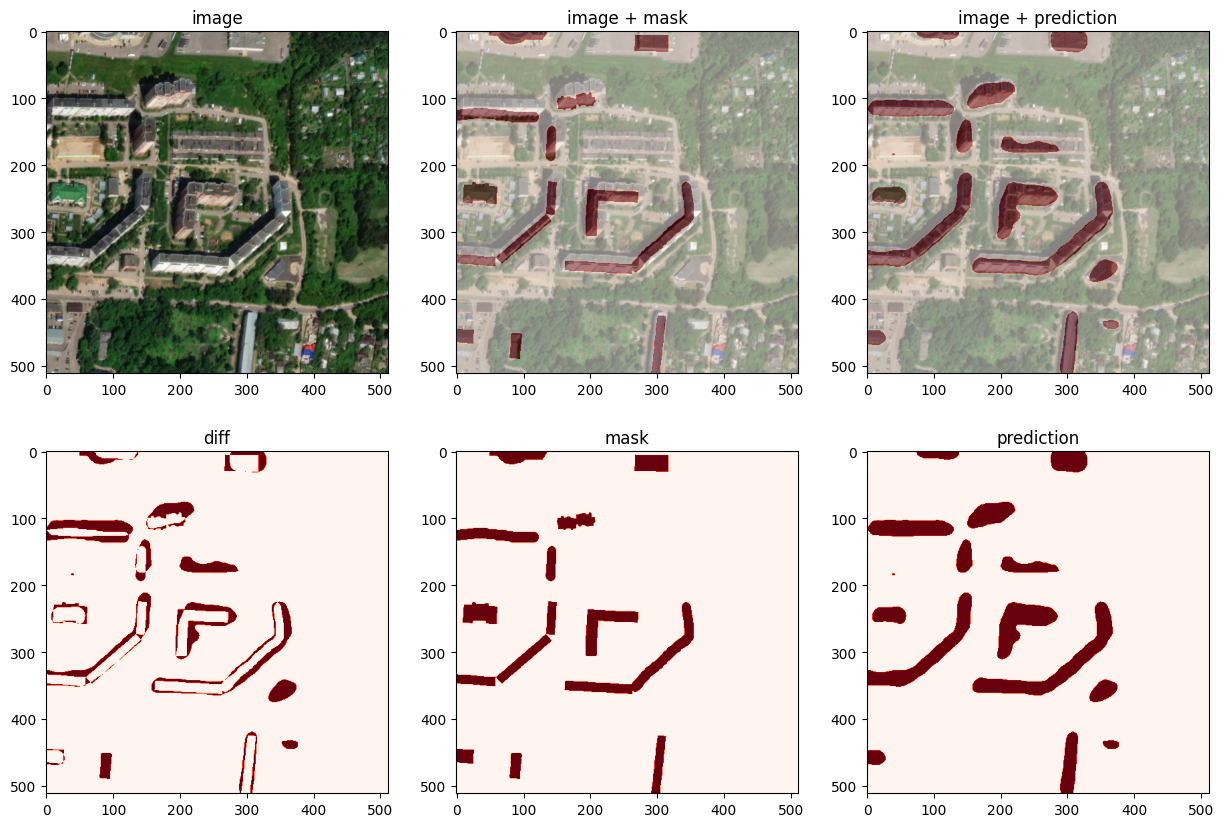

In [5]:
show_random_crop_results(image, mask)

In [6]:
from src.modelling.predict import ShiftedPredictor

predictor = ShiftedPredictor(ensemble)

In [7]:
pred = predictor.predict(image)

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

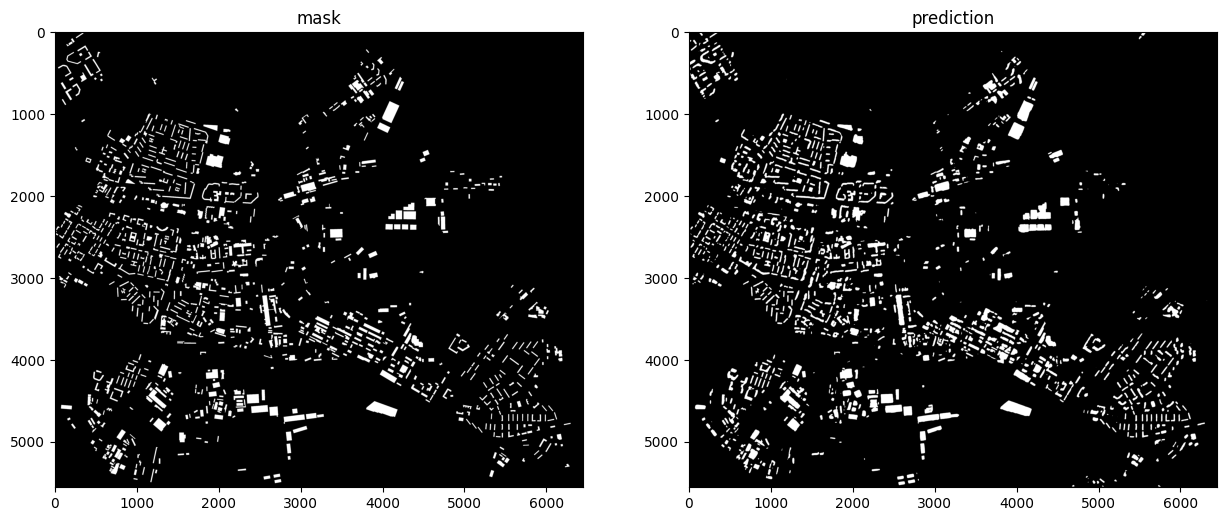

In [8]:
plt.subplots(1, 2, figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.title("mask")
plt.subplot(1, 2, 2)
plt.imshow(pred > 0.5, cmap='gray')
plt.title("prediction")
plt.show()

In [9]:
from src.modelling.metrics import f1_score

binary_pred = (pred > 0.5).astype(np.int16)
f1_score(mask, binary_pred)

0.7309695783590712

In [10]:
idxs = (4, 12, 1, 5, 9)
all_images = [r.read_image(idx) for idx in idxs]
all_masks = [r.read_mask(idx) for idx in idxs]

In [11]:
result = predictor.validate(all_images, all_masks, threshold=0.5)
print(f"F1 score: {result}")

  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

F1 score: 0.7020796622692715
